In [1]:
cd /data/cilia/notebooks

/data/cilia/notebooks


In [2]:
from __future__ import print_function
from builtins import range
import pandas as pd
import numpy as np
import os, glob, random, math
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

In [3]:
labels_path = '../input/labels.txt'
labels = pd.read_table(labels_path, sep=' ', names=['Patient', 'Abnormality', 'class'])

In [60]:
labels.head()

,Patient,Abnormality,class
0,7297,4,1
1,7280,3,1
2,7287,3,1
3,7286,4,1
4,7284,1,0


In [4]:
labels.groupby('class').count()

,Patient,Abnormality
class,,
0,96,96
1,53,53


In [5]:
labels.groupby('Abnormality').count()

,Patient,class
Abnormality,,
1,82,82
2,14,14
3,13,13
4,40,40


In [6]:
missing = 0
for file in os.listdir('../input/rotation'):
    patient = file[:4]
    if labels.loc[labels['Patient'] == int(patient)].shape[0] == 0:
        print('Missing:', file)
        missing += 1
print('Total missing labels: ', missing)

Missing: 9050l.npy
Missing: 9048j.npy
Missing: 90346.npy
Missing: 90348.npy
Missing: 90347.npy
Missing: 90341.npy
Missing: 9048d.npy
Missing: 9050d1.npy
Missing: 9050p.npy
Missing: 9048a.npy
Missing: 90349.npy
Missing: 9050n.npy
Missing: 9048g.npy
Missing: 9050c1.npy
Missing: 9050q.npy
Total missing labels:  15


In [7]:
rota = np.load('../input/rotation/1001-1.npy')

In [8]:
rota.shape

(250, 480, 640)

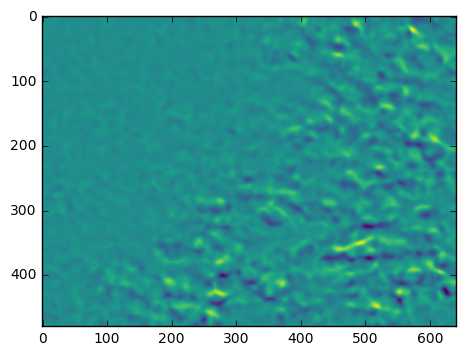

In [9]:
plt.imshow(rota[200], cmap='viridis')
plt.show()

In [10]:
def get_blocks(lis, n):
    for i in range(0, len(lis), int(n)):
        yield lis[i:i + int(n)]

def mean(lis):
    return sum(lis) / len(lis)

def preprocess_data(vid, labels, y_img_size, x_img_size, block=20, visualize=False):
    patient = vid[:4]
    label_df = labels.loc[labels['Patient'] == int(patient)]
    label = label_df.iloc[0]['class']
    array = np.load('../input/rotation/' + vid)
    resized_array = [cv2.resize(frame, (y_img_size, x_img_size))
                     for frame in array]
    block_size = math.ceil(len(resized_array) / block)
    new_array = []
    for block_slice in get_blocks(resized_array, block_size):
        block_slice = list(map(mean, zip(*block_slice)))
        new_array.append(block_slice)
    if visualize:
        fig = plt.figure()
        for n, frame in enumerate(new_array):
            y = fig.add_subplot(4, 5, n + 1)
            y.imshow(frame, cmap='gray')
        plt.show()
    if label == 0: label = np.array([1,0])
    elif label == 1: label = np.array([0,1])
    return np.array(new_array), label

def name_format(name):
    if '-' in name:
        return name[:-4]
    else:
        return name[:4] + '-' + name[4:-4]

In [11]:
videos = os.listdir('../input/rotation')
labels = pd.read_table(labels_path, sep=' ',
                       names=['Patient', 'Abnormality', 'class'])

clean_labels = labels.drop_duplicates()

canonical_labels = clean_labels[(clean_labels['Abnormality'] == 4)
                          | (clean_labels['Abnormality'] == 1)]

canonical_labels.groupby('class').count()

,Patient,Abnormality
class,,
0,63,63
1,39,39


In [12]:
canon_arrays = []
num_canon = 0
abnormal = 0
normal = 0
total_files = len(os.listdir('../input/rotation'))
for file in os.listdir('../input/rotation'):
    patient = file[:4]
    row = canonical_labels.loc[canonical_labels['Patient'] == int(patient)]
    if row.shape[0] == 0:
        pass
    else:
        canon_arrays.append(file)
        num_canon += 1
        if(row['class'].values == 1): abnormal += 1
        else: normal += 1
print('Total canonical files: ', num_canon)
print('Total not canonical: ', total_files - num_canon)
print('Total valid abnormal files:', abnormal)
print('Total valid normal files: ', normal)
assert(len(canon_arrays) == normal + abnormal)

Total canonical files:  266
Total not canonical:  59
Total valid abnormal files: 127
Total valid normal files:  139


In [82]:
x_size = 120
y_size = 160
block = 10
save_path = '../input/rotation_resized_{}_{}_{}/'.format(y_size,
                                                         x_size,
                                                         block)
if not os.path.exists(save_path):
    os.mkdir(save_path)

In [ ]:
scalar = 155555
resized_list = []
def resize_array(resized_list, save=False, save_as_one=False):
    for n, vid in enumerate(canon_arrays):
        if n % 25 == 0:
            print(n)
        try:
            img_data, label = preprocess_data(vid, clean_labels, 
                                              y_img_size=y_size,
                                              x_img_size=x_size,
                                              block=block)
            if img_data.shape[0] != block:
                print(img_data.shape)
            img_data = np.array((img_data * scalar).astype(np.int16))
            resized_list.append([img_data, label])
        except KeyError as e:
            print(str(e))
        file_path = save_path + '{}_{}_{}_{}.npy'.format(name_format(vid),
                                                 y_size, 
                                                 x_size,
                                                 block)
        if save:
            if not os.path.exists(file_path):
                np.save(file_path, resized_list[n])
    if save_as_one:
        np.save('../input/' + 'stack_{}_{}_{}.npy'.format(y_size, 
                                                          x_size,
                                                          block),
                resized_list)
resize_array(resized_list, save_as_one=True)

0
25
50


In [15]:
# del resized_list

In [16]:
x = tf.placeholder('float')
y = tf.placeholder('float')

In [75]:
def conv3d(x, W):
    return tf.nn.conv3d(x, W, strides=[1,1,1,1,1], padding='SAME')

def max_pool3d(x):
    return tf.nn.max_pool3d(x, ksize=[1,2,2,2,1],
                            strides=[1,2,2,2,1], padding='SAME')
def make_cnn(x):
#     x = tf.placeholder('float')
    weights = {'W_conv1': tf.Variable(tf.random_normal([3,3,3,1,32])),
               'W_conv2': tf.Variable(tf.random_normal([3,3,3,32,64])),
               'W_fc': tf.Variable(tf.random_normal([57600, 1024])),
               'out': tf.Variable(tf.random_normal([1024, n_classes]))}
    
    biases = {'b_conv1':tf.Variable(tf.random_normal([32])),
               'b_conv2':tf.Variable(tf.random_normal([64])),
               'b_fc':tf.Variable(tf.random_normal([1024])),
               'out':tf.Variable(tf.random_normal([n_classes]))}
    
    x = tf.reshape(x, shape=[-1, x_size, y_size, block, 1])
    
    conv1 = tf.nn.relu(conv3d(x, weights['W_conv1']) + biases['b_conv1'])
    conv1 = max_pool3d(conv1)
    conv2 = tf.nn.relu(conv3d(conv1, weights['W_conv2']) + biases['b_conv2'])
    conv2 = max_pool3d(conv2)
    
    fc = tf.reshape(conv2, [-1, 57600])
    fc = tf.nn.relu(tf.matmul(fc, weights['W_fc']) + biases['b_fc'])
    fc = tf.nn.dropout(fc, dropout)
    
    output = tf.matmul(fc, weights['out']) + biases['out']
    return output

def train_cnn(x):
#     random.seed(2017)
#     random.shuffle(rota_data)
#     split_point = int(round(train_test_split * len(rota_data)))
#     train = rota_data[:split_point]
#     test = rota_data[split_point:]
    y = tf.placeholder('float')
    prediction = make_cnn(x)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=y))
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(cost)
    epochs = 10
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        successful_runs = 0
        total_runs = 0
        for epoch in range(epochs):
            epoch_loss = 0
            for data in train:
                total_runs += 1
                try:
                    X = data[0]
                    Y = data[1]
                    _, c = sess.run([optimizer, cost], feed_dict={x:X, y:Y})
                    epoch_loss += c
                    successful_runs += 1
                except Exception as e:
                    print(str(e))
            print('Epoch', epoch+1, 'completed out of ', epochs, 'loss: ', epoch_loss)
            
            correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))
            accuracy = tf.reduce_mean(tf.cast(correct, 'float'))
            print('Train Accuracy: ', accuracy.eval({x:[i[0].astype(np.float32) for i in train],
                                               y:[i[1] for i in train]}))
            print('Valid Accuracy: ', accuracy.eval({x:[i[0].astype(np.float32) for i in test],
                                               y:[i[1] for i in test]}))
        print('Done.')
        print('Accuracy: ', accuracy.eval({x:[i[0].astype(np.float32) for i in test],
                                           y:[i[1].astype(np.float32) for i in test]}))
        print('Number of successful runs: ', successful_runs/total_runs)


In [18]:
data_path = '../input/rotation_resized_80_60_10/'
rota_data = os.listdir(data_path)
much_data = np.load('../input/stack_80_60_10.npy')

In [84]:
x_size = 60
y_size = 80
block = 10
n_classes = 2
batch_size = 10
dropout = 0.5
train_test_split = 0.5

In [85]:
# much_data[0][0]

In [86]:
random.seed(2017)
random.shuffle(rota_data)
# split_point = int(round(train_test_split * len(rota_data)))
train = much_data[:100]
test = much_data[100:200]

In [87]:
train_cnn(x)

Epoch 1 completed out of  10 loss:  84137343904.0
Train Accuracy:  0.53
Valid Accuracy:  0.53
Epoch 2 completed out of  10 loss:  64859722672.0
Train Accuracy:  0.68
Valid Accuracy:  0.57
Epoch 3 completed out of  10 loss:  34727291408.0
Train Accuracy:  0.65
Valid Accuracy:  0.45
Epoch 4 completed out of  10 loss:  44630757920.0
Train Accuracy:  0.56
Valid Accuracy:  0.61
Epoch 5 completed out of  10 loss:  30973724432.0
Train Accuracy:  0.76
Valid Accuracy:  0.58
Epoch 6 completed out of  10 loss:  15688133197.0
Train Accuracy:  0.77
Valid Accuracy:  0.62
Epoch 7 completed out of  10 loss:  4665753356.0
Train Accuracy:  0.87
Valid Accuracy:  0.48
Epoch 8 completed out of  10 loss:  4094223470.0
Train Accuracy:  0.83
Valid Accuracy:  0.47
Epoch 9 completed out of  10 loss:  4263350736.0
Train Accuracy:  0.92
Valid Accuracy:  0.59
Epoch 10 completed out of  10 loss:  8355974056.0
Train Accuracy:  0.93
Valid Accuracy:  0.57
Done.
Accuracy:  0.63
Number of successful runs:  1


In [64]:
# high = []
# low = []
# scalar = 155555
# for i in much_data:
# #     high.append(np.max((i[0] * scalar).astype(np.int16)))
# #     low.append(np.min((i[0] * scalar).astype(np.int16)))
#     print((i[0] * scalar).astype(np.int16))
#     print((i[0] * scalar).astype(np.int16))
# # print(max(high))
# # print(min(low))

In [115]:
test = (much_data[5][0] * scalar).astype(np.int16)

In [116]:
test[0].shape

(60, 80)

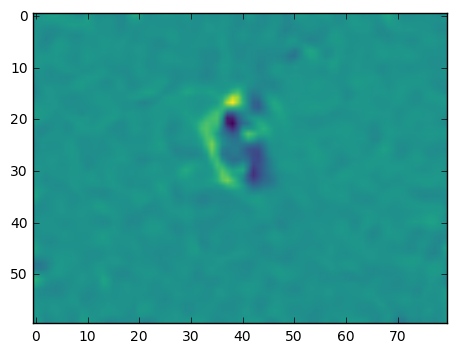

In [118]:
plt.imshow(test[5], cmap='viridis')
plt.show()

In [52]:
import matplotlib.animation as animation
plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'

In [63]:
test_a = np.load('../input/rotation_resized_80_60_20/7286-1_80_60_20.npy')
test_b = np.load('../input/rotation_resized_80_60_20/7286-3_80_60_20.npy')
test_c = np.load('../input/rotation_resized_80_60_20/7286-5_80_60_20.npy')

In [66]:
a = []
for i in test_a[0]:
    a.append(i)
    
b = []
for i in test_b[0]:
    b.append(i)
    
c = []
for i in test_c[0]:
    c.append(i)

In [67]:
ImageMagickWriter = animation.ImageMagickWriter()

def animate(pat, gifname):
    # Based on @Zombie's code
    fig = plt.figure()
    anim = plt.imshow(pat[0], cmap=plt.cm.bone)
    def update(i):
        anim.set_array(pat[i])
        return anim,
    
    a = animation.FuncAnimation(fig, update, frames=range(len(pat)), interval=20, blit=True)
    a.save(gifname, writer=ImageMagickWriter)
    
animate(a, 'test_a.gif')
animate(b, 'test_b.gif')
animate(c, 'test_c.gif')


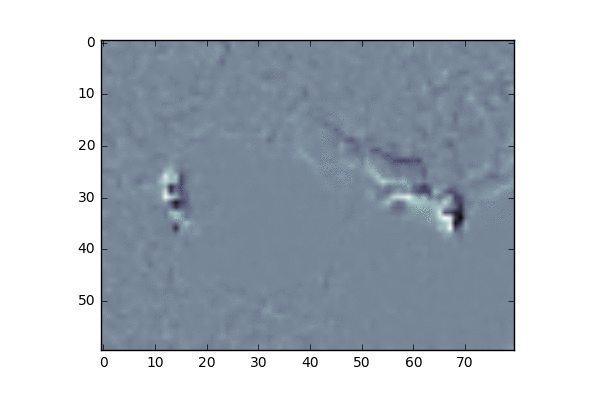

In [68]:
IMG_TAG = """<img src="data:image/gif;base64,{0}">"""

import base64
from IPython.display import HTML

def display_gif(fname):
    data = open(fname, "rb").read()
    data = base64.b64encode(data)
    return HTML(IMG_TAG.format(data))

display_gif("test_a.gif")


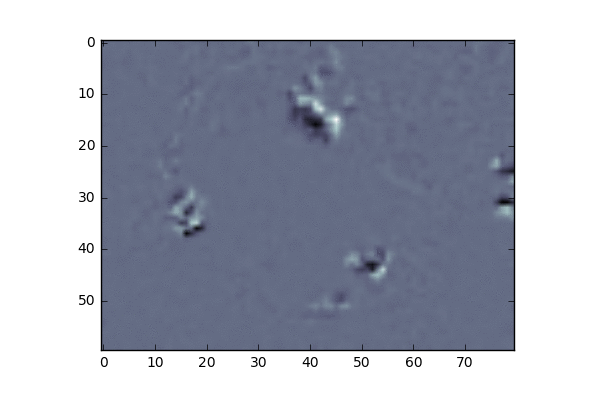

In [69]:
display_gif("test_b.gif")


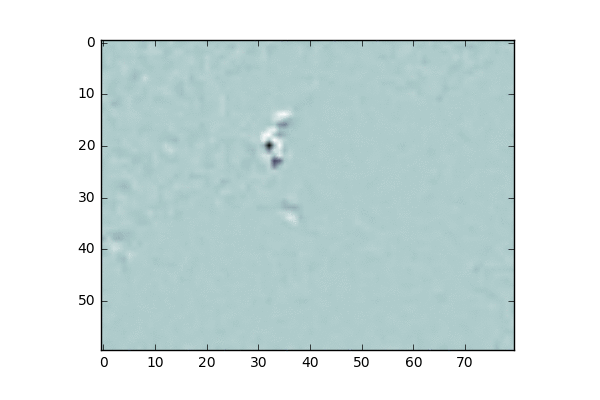

In [70]:
display_gif("test_c.gif")